# TO DO:
seperate library from plots

In [46]:
# Magnozzi data for gold
# https://refractiveindex.info/data_csv.php?datafile=database/data-nk/main/Au/Magnozzi-25C.yml
# Johnsonn and Christy
gold = np.genfromtxt('Magnozzi-25C.csv', delimiter=',', skip_header=1).T
_gold_wavelen = gold[0]*10**-6
_n_gold = gold[1] - 1j*gold[2]
def n_gold(wavelen):
    assert wavelen > 252*10**-9 and wavelen < 1.45*10**-6 
    wavelen = np.asarray(wavelen)
    if wavelen.ndim == 0:  # If input is a scalar (0-dimensional array)
        wavelen = np.array([wavelen])
    
    min = np.argmin(np.abs(wavelen[:,np.newaxis] - _gold_wavelen), axis=1)
    return _n_gold[min]


n_ps = 1.5537
n_air = 1
n_water = 1.333
n_glass = 1.499
n_oil = 1.5018
n_glyc = 1.461


@dataclass
class DesignParams():
    n_oil: float = n_oil
    n_oil0: float = n_oil
    n_glass: float = n_glass
    n_glass0: float = n_glass
    n_medium: float = n_water
    t_oil0: float = 100*10**-6
    t_oil: float = 100*10**-6
    t_glass: float = 160*10**-6
    t_glass0: float = 160*10**-6
    n_scat: float = n_ps
    a: float = 50*10**-9
    z_p: float = a
    z_focus: float = 0
    wavelen: float = 525*10**-9


NA = 1.4

# The polarization of the scattered radiation equals the polarization of the scatterer
polarization = np.array([1, 0, 0]) # x polarization

# Camera definitions
camsize = 2 # micron
#sampling points for detector
xs = np.linspace(-camsize/2, camsize/2, 64)*10**-6
ys = np.linspace(-camsize/2, camsize/2, 64)*10**-6
x, y = np.meshgrid(xs, ys)


phi = np.arctan(y/x)
rs = np.linspace(0, np.sqrt(2)*camsize/2, 200)*10**-6
xy_rs = np.argmin(np.abs(np.sqrt(x**2 + y**2)[:,:,np.newaxis] - rs), axis=2)
default_camera_params = (xs, ys, rs, phi, xy_rs)

# Optical functions: Propagation
- Core of program
- Based on a combination of three papers:
    1. B. Richards and E. Wolf (1959)
        - Imaging through objective
        - Richards-Wolf integral(s)
    1. François Aguet et al. (2009)
        - Fluorescence
        - Propagation through layers
    1. Reza Gholami Mahmoodabadi et al. (2020)
        - iSCAT
        - Dielectric scatterer

### Electric field on camera
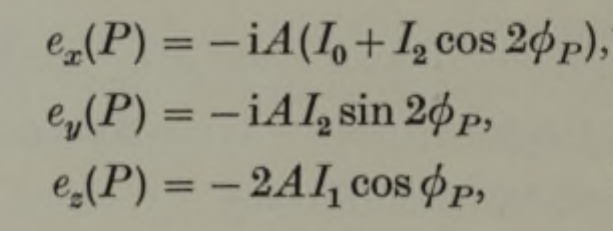
B. Richards and E. Wolf

### Integrals including intensity modification by propagation through layers
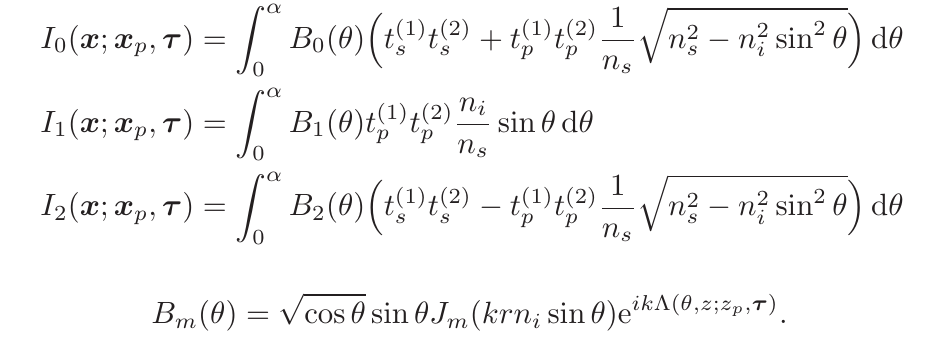
François Aguet et al.

### OPD
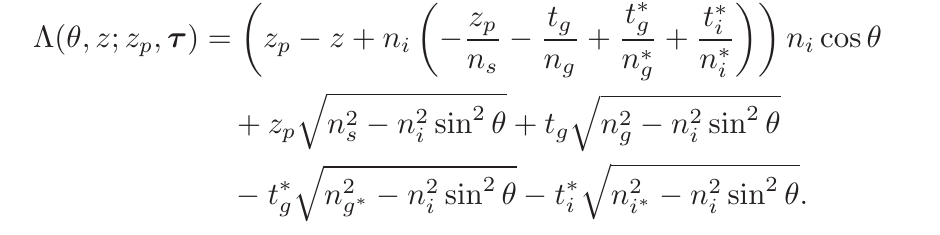
François Aguet et al.

### OPD modification for suspended particles
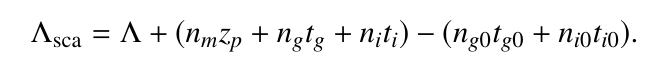
Reza Gholami Mahmoodabadi et al.

In [53]:
def opd(oil_angle, p):
    n_oil = p.n_oil
    n_oil0 = p.n_oil0
    t_oil = p.t_oil
    t_oil0 = p.t_oil0
    t_glass = p.t_glass
    t_glass0 = p.t_glass0
    n_glass = p.n_glass
    n_glass0 = p.n_glass0
    n_medium = p.n_medium
    z_p = p.z_p
    z_focus = p.z_focus

    opd = (n_oil*np.cos(oil_angle)*(z_p - z_focus + n_oil*(-z_p/n_medium - t_glass/n_glass + t_glass0/n_glass0 + t_oil0/n_oil0)) +
        z_p*np.sqrt(n_medium**2 - n_oil**2 *np.sin(oil_angle)**2) + t_glass*np.sqrt(n_glass**2 - n_oil**2 *np.sin(oil_angle)**2) -
        t_glass0*np.sqrt(n_glass0**2 - n_oil**2 *np.sin(oil_angle)**2) - t_oil0*np.sqrt(n_oil0**2 - n_oil**2 *np.sin(oil_angle)**2))
    return opd + n_medium*z_p + n_glass*t_glass + n_oil*t_oil - n_glass0*t_glass0 - n_oil0*t_oil0


def snells_law(n1, n2, incident_angle):
    return np.arcsin(n1 / n2 * np.sin(incident_angle))
    

def t_p(n1, n2, incident_angle, transmitted_angle):
    return 2*n1*np.cos(incident_angle)/(n2*np.cos(incident_angle) + n1*np.cos(transmitted_angle))

def t_s(n1, n2, incident_angle, transmitted_angle):
    return 2*n1*np.cos(incident_angle)/(n1*np.cos(incident_angle) + n2*np.cos(transmitted_angle))


def B(n, angle, r, p):
    wavelen = p.wavelen
    n_oil = p.n_oil
    k = 2*np.pi/wavelen #FIXED: used to be same as polarization k
    return np.sqrt(np.cos(angle))*np.sin(angle)*jv(n, k*r*n_oil*np.sin(angle))*np.exp(1j*k*opd(angle, p))


def Integral_0(r, p):
    n_medium = p.n_medium
    n_glass = p.n_glass
    n_oil = p.n_oil
    capture_angle_oil = np.arcsin(min(NA/n_oil, 1))

    def integrand(angle):
        glass_angle = snells_law(n_medium, n_glass, angle)
        aperture_angle = snells_law(n_glass, n_oil, glass_angle)
        t_p_1 = t_p(n_medium, n_glass, angle, glass_angle)
        t_p_2 = t_p(n_glass, n_oil, glass_angle, aperture_angle)
        t_s_1 = t_s(n_medium, n_glass, angle, glass_angle)
        t_s_2 = t_s(n_glass, n_oil, glass_angle, aperture_angle)
        return (B(0, aperture_angle, r, p)*
            (t_s_1*t_s_2 + t_p_1*t_p_2/n_medium*np.sqrt(n_medium**2 - n_oil**2*np.sin(aperture_angle)**2)))

    return quad(integrand, 0, capture_angle_oil, complex_func=True)[0]

def Integral_1(r, p):
    n_medium = p.n_medium
    n_glass = p.n_glass
    n_oil = p.n_oil
    capture_angle_oil = np.arcsin(min(NA/n_oil, 1))
    def integrand(angle):
        glass_angle = snells_law(n_medium, n_glass, angle)
        aperture_angle = snells_law(n_glass, n_oil, glass_angle)
        t_p_1 = t_p(n_medium, n_glass, angle, glass_angle)
        t_p_2 = t_p(n_glass, n_oil, glass_angle, aperture_angle)
        return (B(1, aperture_angle, r, p)*
            t_p_1*t_p_2 * n_oil/n_glass * np.sin(aperture_angle))

    return quad(integrand, 0, capture_angle_oil, complex_func=True)[0]

def Integral_2(r, p):
    n_medium = p.n_medium
    n_glass = p.n_glass
    n_oil = p.n_oil
    capture_angle_oil = np.arcsin(min(NA/n_oil, 1))
    def integrand(angle):
        glass_angle = snells_law(n_medium, n_glass, angle)
        aperture_angle = snells_law(n_glass, n_oil, glass_angle)
        t_p_1 = t_p(n_medium, n_glass, angle, glass_angle)
        t_p_2 = t_p(n_glass, n_oil, glass_angle, aperture_angle)
        t_s_1 = t_s(n_medium, n_glass, angle, glass_angle)
        t_s_2 = t_s(n_glass, n_oil, glass_angle, aperture_angle)
        return (B(2, aperture_angle, r, p)*
            (t_s_1*t_s_2 - t_p_1*t_p_2/n_medium*np.sqrt(n_medium**2 - n_oil**2*np.sin(aperture_angle)**2)))

    return quad(integrand, 0, capture_angle_oil, complex_func=True)[0]

def calculate_intensities(scatter_field, p, cp = default_camera_params):
    xs, ys, rs, phi, xy_rs = cp
    wavelen = p.wavelen
    # Lambdas to avoid calculating if it is not necessary
    I_0 = lambda: np.array([Integral_0(r, p) for r in rs])[xy_rs]
    I_1 = lambda: np.array([Integral_1(r, p) for r in rs])[xy_rs]
    _I_2 = None
    I_2 = lambda: _I_2 if _I_2 is not None else np.array([Integral_2(r, p) for r in rs])[xy_rs]

    empty = np.zeros((len(xs), len(ys)))
    e_x = I_0() + I_2()*np.cos(2*phi) if polarization[0] != 0 else empty
    e_y = I_2()*np.sin(2*phi) if polarization[1] != 0 else empty
    e_z = -2j*I_1()*np.cos(phi) if polarization[2] != 0 else empty
    detector_field = -1j/wavelen*scatter_field*np.array([e_x, e_y, e_z])


    reference_field = np.ones_like(detector_field)*polarization[:,np.newaxis,np.newaxis]
    interference_intensity = 2*np.sum(np.real((detector_field*np.conj(reference_field))), axis=0)
    scatter_intensity = np.sum(np.abs(detector_field)**2, axis=0)
    reference_intensity = np.sum(np.abs(reference_field)**2, axis=0)
    return {'if':interference_intensity,
        'scat':scatter_intensity,
        'ref':reference_intensity,
        'sig':scatter_intensity+interference_intensity,
        'tot':interference_intensity+scatter_intensity+reference_intensity}

# Optical functions: iSCAT, scattering
Based on  R.G. Mahmoodabadi et al. (2020)

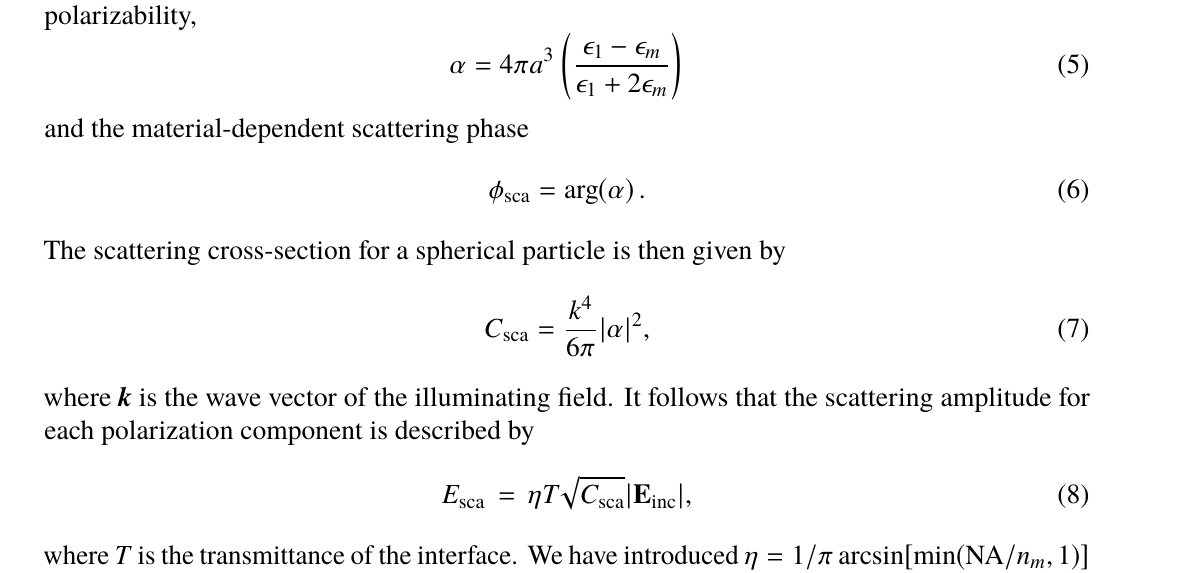

Contains Rayleigh approximation (dipole approximation)



In [ ]:
def calculate_scatter_field(p):
    n_glass = p.n_glass
    n_medium = p.n_medium
    n_oil = p.n_oil
    n_scat = p.n_scat
    a = p.a
    wavelen = p.wavelen

    scatter_field = 1 + 0j
    # Reference field polarization, phase and magnitude
    E_reference = polarization[:,np.newaxis,np.newaxis] # x_polarization with size 1

    # Backpropagate reference to excitation
    r_gm = (n_glass - n_medium)/(n_glass + n_medium)
    t_gm = 2*n_glass/(n_glass + n_medium)
    t_go = 2*n_glass/(n_glass + n_oil)
    E_excitation = E_reference/t_go/r_gm*t_gm
    scatter_field = E_excitation*scatter_field

    # Magnitude and phase of scatter field
    capture_angle_medium = np.arcsin(min(NA/n_medium, 1))
    collection_efficiency = capture_angle_medium/np.pi
    x_mie = 2*np.pi*a*n_medium / wavelen
    k = 2*np.pi*n_medium/wavelen
    e_scat = n_scat**2
    e_medium = n_medium**2
    polarizability = 4*np.pi*a**3*(e_scat-e_medium)/(e_scat + 2*e_medium)
    
    scatter_cross_section = k**4/6/np.pi *np.abs(polarizability)**2

    scatter_phase = np.angle(polarizability)
    
    scatter_field *= np.sqrt(scatter_cross_section)*collection_efficiency*np.exp(1j*scatter_phase)
    return scatter_field

# 2004 Physical review Lindfors